In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

In [3]:
covid_data = pd.read_csv('../data/covid/covid_data.csv')
display(covid_data.head(2))

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0


In [4]:
vaccinations_data = pd.read_csv('../data/covid/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]
display(vaccinations_data.head(2))

,country,date,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,Afghanistan,2021-02-22,0.0,0.0,0.0,NaN,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
1,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."


В таблице **covid_data** данные о заболеваемости представлены для каждого региона (штата) страны за каждый день. 

В таблице **vaccinations_data** параметры вакцинирования отображены для всех стран на каждый день, без учёта регионов. 

В данных много пропусков, а также неверно введённых значений. Например, для США и Великобритании в большинстве записей таблицы covid_data число выздоровевших людей равно 0. Пока пропустим, но вообще эти страны подлежали бы исключению из данных или нам понадобился бы дополнительный источник данных, из которого мы смогли бы получить недостающую информацию.

Признаки confirmed, deaths, recovered, total_vaccination, people_vaccinated, people_fully_vaccinated — накопительные.

При объединении таблиц необходимо учитывать следующие нюансы:

* В таблице covid_data необходимо предварительно рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране;
* В таблицах не совпадает число стран, а иногда и их названия. При объединении таблиц по столбцу мы теряем данные. Избежать этого можно ручными преобразованиями данных — искать различия в названиях стран в таблицах и преобразовывать их. Пока пропустим;
* Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные внутренним соединением, мы можем потерять большое количество наблюдений в таблице covid_data;

In [7]:
# группируем по стране
covid_data = covid_data.groupby( 
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

# преобразуем даты в формат datetime
covid_data['date'] = pd.to_datetime(covid_data['date'])
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

# создадим признак больных на данный момент (active)
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

# cоздадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

display(covid_data.head(2))

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered
881,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN
920,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
display(f'Данные о заболеваемости с {covid_data.date.min().strftime("%Y-%m-%d")} по {covid_data.date.max().strftime("%Y-%m-%d")}')

'Данные о заболеваемости с 2020-01-22 по 2021-05-29'

In [45]:
display(f'Данные о вакцинации с {vaccinations_data.date.min().strftime("%Y-%m-%d")} по {vaccinations_data.date.max().strftime("%Y-%m-%d")}')

'Данные о вакцинации с 2020-12-02 по 2021-09-06'

In [48]:
covid_df = covid_data.merge(vaccinations_data, how='left', on=['date', 'country'])
display(covid_df.head(2))

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
covid_df['death_rate'] = covid_df['deaths']*100/covid_df['confirmed']
covid_df['recover_rate'] = covid_df['recovered']*100/covid_df['confirmed']

In [51]:
# Какова максимальная летальность в США (United States) за весь период?
covid_df[covid_df['country'] == 'United States']['death_rate'].max()

7.189542483660131

In [52]:
# Чему равен средний процент выздоровевших в России (Russia)?
covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean()

67.06273489477657

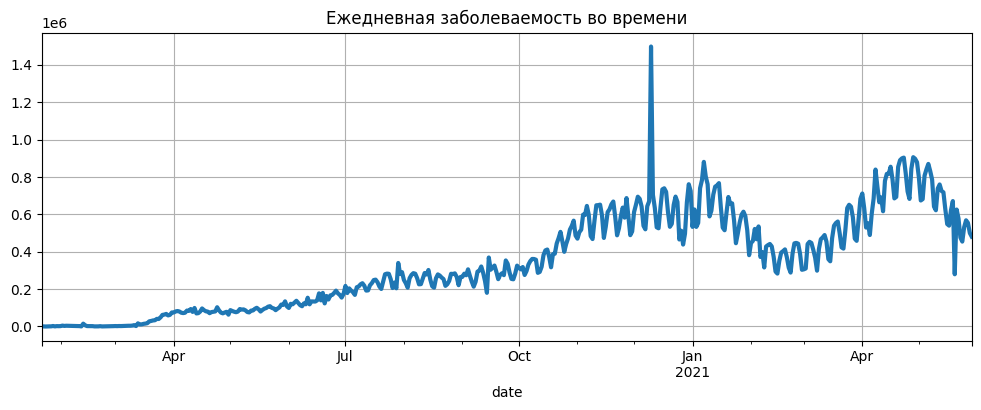

In [53]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость во времени',
    grid = True,
    lw=3
);

На графике выше отчётливо виден умеренный начальный рост заболеваемости, после чего наблюдается её резкое повышение в середине октября 2020 года, а в декабре 2020 года — аномальная вспышка коронавируса (зафиксировано более 1.4 млн. заболевших в день). Такой резкий максимум, возможно, является ошибкой в данных и требует более детального разбора. Далее заметно постепенное уменьшение числа ежедневно фиксируемых случаев и наступление второй волны в марте 2021 года. Наконец, начиная с мая 2021 года наблюдается очередной спад.

Пилообразность графика (подъёмы и спады с периодом в 7 дней) может быть связана с рабочими и выходными днями.

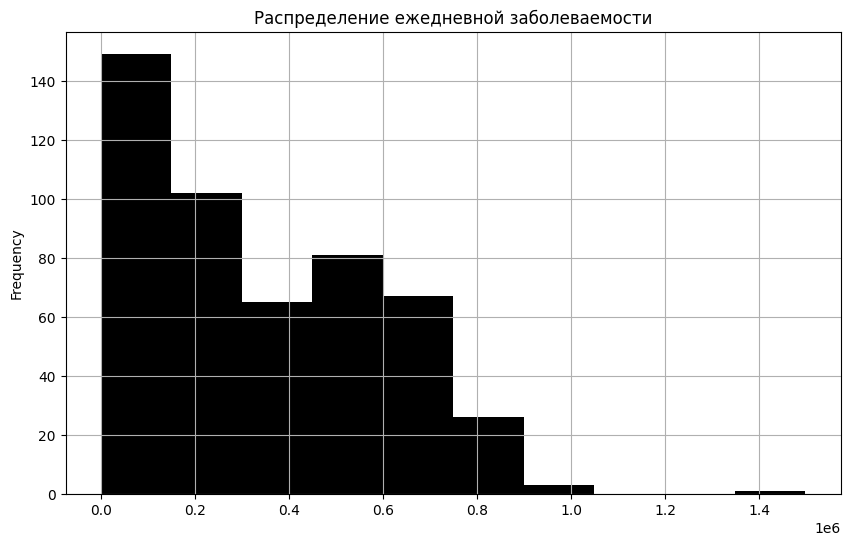

In [54]:
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=10
);

Мы видим модальное значение около нуля (от 0 до примерно 150 тыс. заболеваний в день), то есть большинство наблюдений сосредоточено в первом интервале, далее частота постепенно падает. Это связано с тем, что долгое время распространение вируса было довольно слабым.

В глаза бросается «пенёк», соответствующий резкой вспышке заболеваемости, которую мы видели ранее. Его высота очень мала, ведь такое наблюдение единственное. Даже на гистограмме кажется, что данное наблюдение является аномальным и, скорее всего, представляет собой выброс.

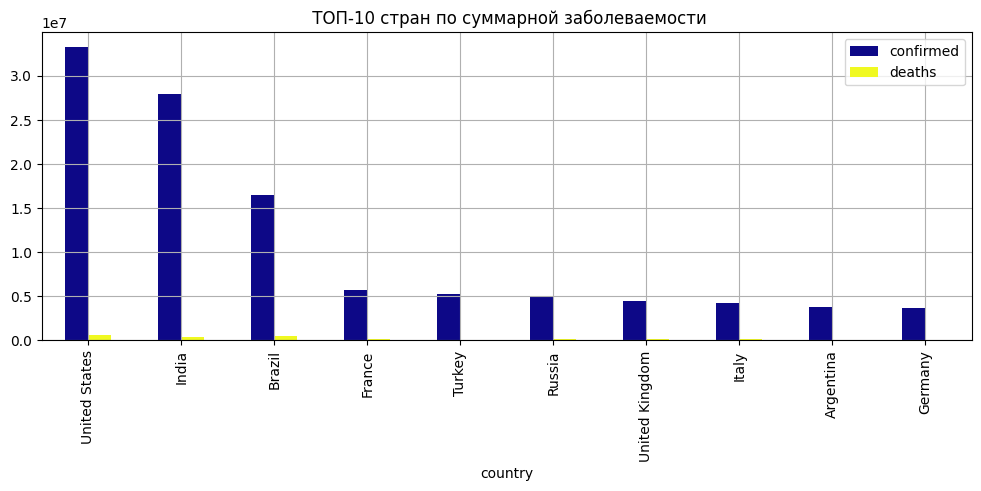

In [62]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma',
    title=' ТОП-10 стран по суммарной заболеваемости',
);

Лидерами по числу заболевших являются Соединённые Штаты, Индия и Бразилия.
Отношение числа умерших к числу заболевших весьма низкое. По косвенным признакам можно предположить разные методики учёта заболевших.

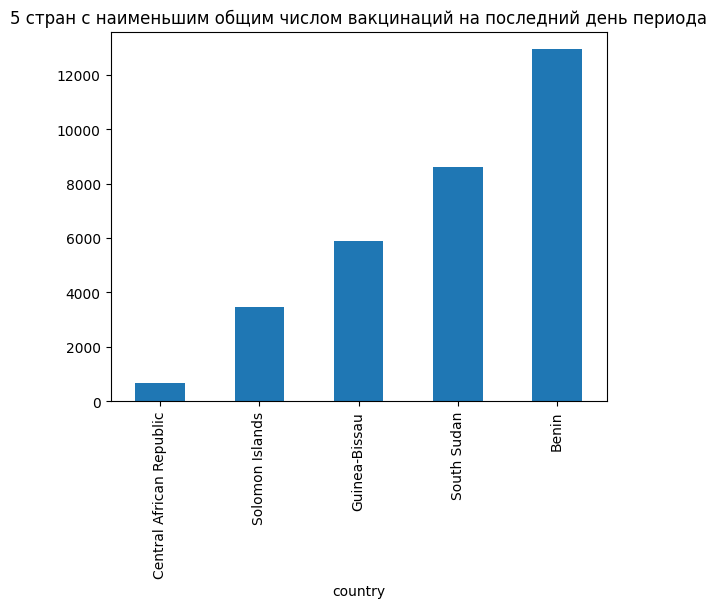

In [65]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(
    kind='bar',
    title='5 стран с наименьшим общим числом вакцинаций на последний день периода'
);

Наименьшее кол-во кацинаций в ЦАР

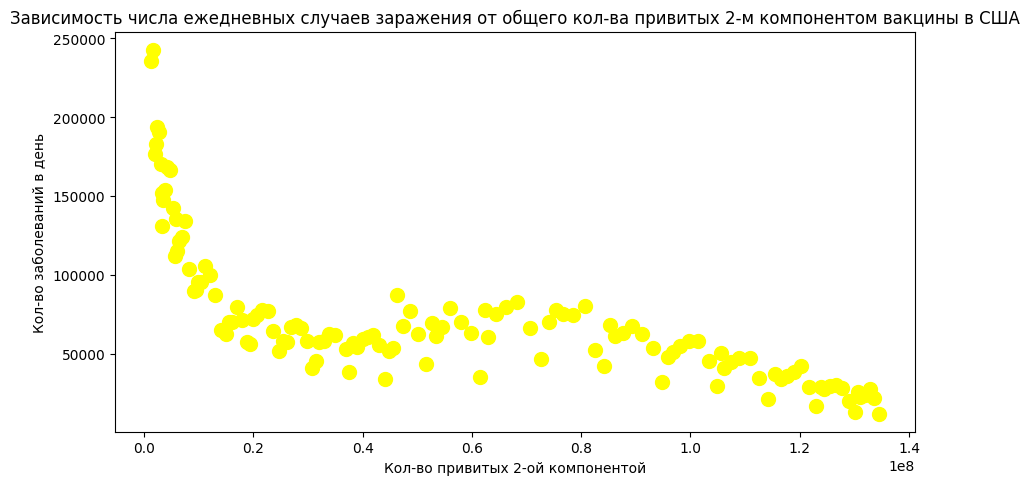

In [78]:
us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0,0,1,1])
axes.scatter(
    x=us_data['people_fully_vaccinated'],
    y=us_data['daily_confirmed'],
    marker='o', # вид маркера
    s=100, # размер маркера
    c='yellow' # цвет маркера
)
axes.set_title('Зависимость числа ежедневных случаев заражения от общего кол-ва привитых 2-м компонентом вакцины в США')
axes.set_xlabel('Кол-во привитых 2-ой компонентой')
axes.set_ylabel('Кол-во заболеваний в день');

Из диаграммы видно, что, в основном, с ростом числа привитых вторым компонентом людей заболеваемость падает, замедляясь на уровне около 50 тысяч заболевших в день, и продолжает снижение дальше.

In [111]:
# Подготовим данные, чтобы посчитать, в скольких странах использовалась та или иная вакцина

# удалим строки, в которых не указана вакцина
combination_not_nan = covid_df.dropna(subset=['vaccines']) 

# получим последнюю использованную вакцину в каждой стране
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last()

# разделим строку с комбинацией вакцин на отдельные вакцины
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(','))

# создадим словарь, ключи - уникальные вакцины, а значения — количество стран, в которых они используются
vaccines_dict = {} 
vaccines_dict.setdefault('dsfsd', 0)
for vaccines_list in combination_last:
    for vaccine in vaccines_list:
        vaccines_dict.setdefault(vaccine, 0)
        vaccines_dict[vaccine] += 1
        
# преобразуем словарь в объект Series. Выделим 7 наиболее популярных вакцин, а остальные обозначим как 'other'
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]

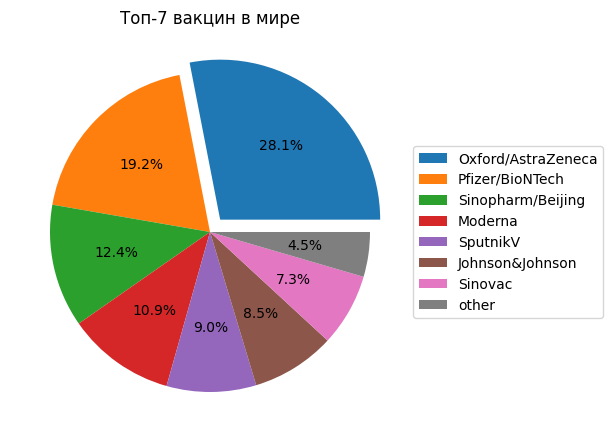

In [121]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    x=vaccines, 
    #labels=vaccines_data.index, # метки, соответствующие значениям
    autopct='%.1f%%', # формат %
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0], # удаление секций от центра
    startangle=0
)
axes.set_title('Топ-7 вакцин в мире')
axes.legend(
    vaccines.index,
    bbox_to_anchor=(0.9,0.5),
    loc="center right",
    fontsize=10, 
    bbox_transform=plt.gcf().transFigure
);

Самой распространённой вакциной является Oxford/AstraZeneca.

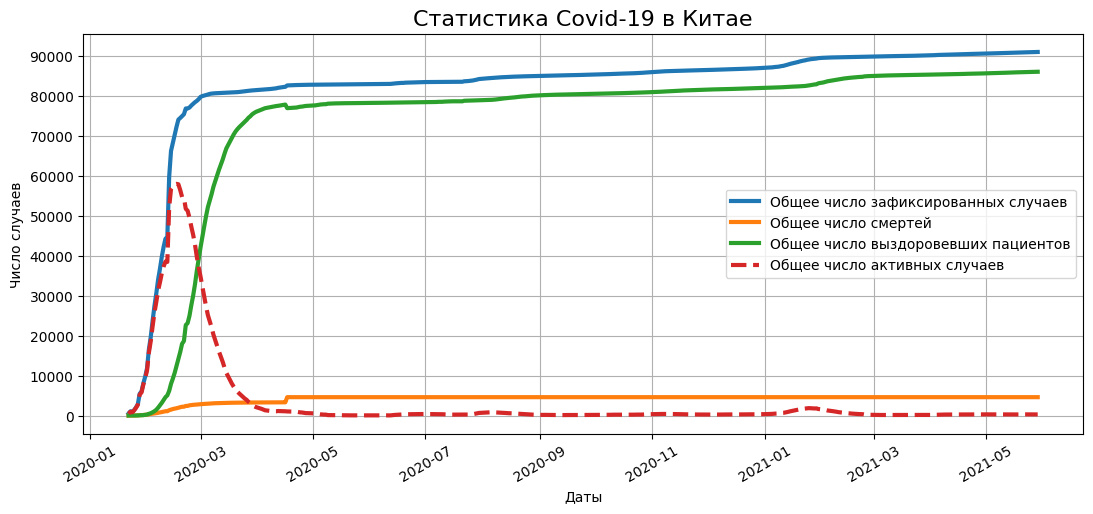

In [133]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

На графике наблюдается резкий рост заболеваемости на начальном периоде до середины февраля 2020 года, после чего видно резкое падение числа активных случаев (примерно в этот период власти Китая ввели тотальный локдаун и прекратили транспортное сообщение со всем миром). Далее число активных случаев только падает, а темп прироста числа заболевших снижается. При этом общее число смертей в Китае остаётся практически на одном уровне (около 5 тысяч), уже начиная с мая 2020 года (новые пациенты умирают крайне редко).

Стоит обратить внимание на сдвиги в графиках апреле 2020. Они являются свидетельством противоречия в данных: общее число выздоровевших пациентов почему-то резко упало, а число умерших возросло. Почему так произошло? Произошёл пересчёт числа заболевших? Данные были утеряны или искажены?

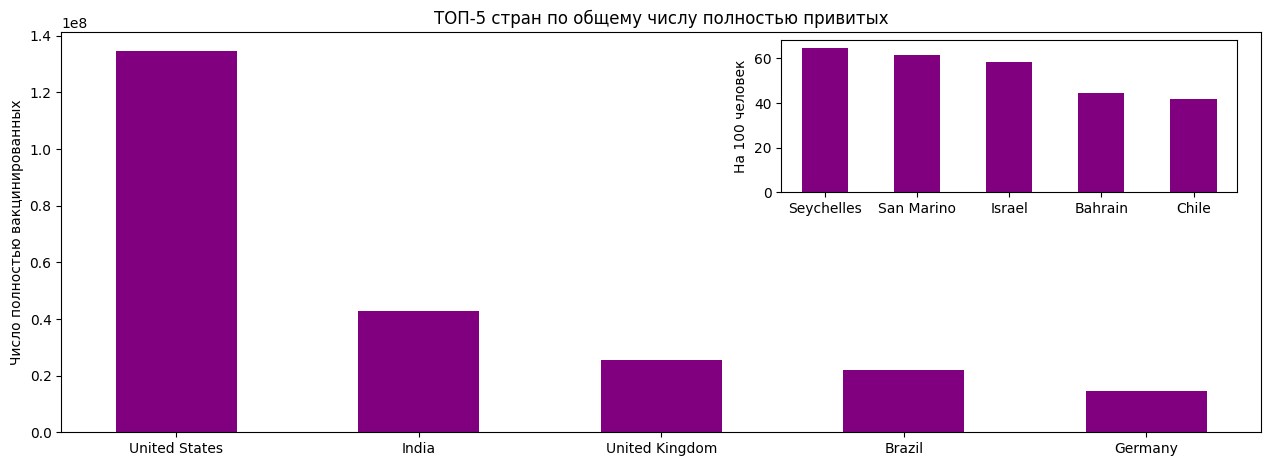

In [145]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

fig = plt.figure(figsize=(12,4))
axes_full = fig.add_axes([0,0,1,1])
axes_full.bar(vacc_country.index, height=vacc_country, width=0.5, color='purple')
axes_full.set_title('ТОП-5 стран по общему числу полностью привитых')
axes_full.set_ylabel('Число полностью вакцинированных')

axes_full_per_hundred = fig.add_axes([0.6, 0.6, 0.38, 0.38])
axes_full_per_hundred.bar(vacc_country_per_hundred.index, height=vacc_country_per_hundred, width=0.5, color='purple')
axes_full_per_hundred.set_ylabel('На 100 человек');

Нетрудно заметить, что два представленных рейтинга отличаются: лидером по числу полностью привитых является США, а вот по числу вакцин на 100 человек населения — Сейшелы. В первый список попали страны с большим количеством населения, которое они активно прививают. Во второй список попали маленькие страны, которые проще всего обеспечить вакциной.

В наш ТОП не попали страны, которые пользуются однокомпонентной вакциной, например Китай.

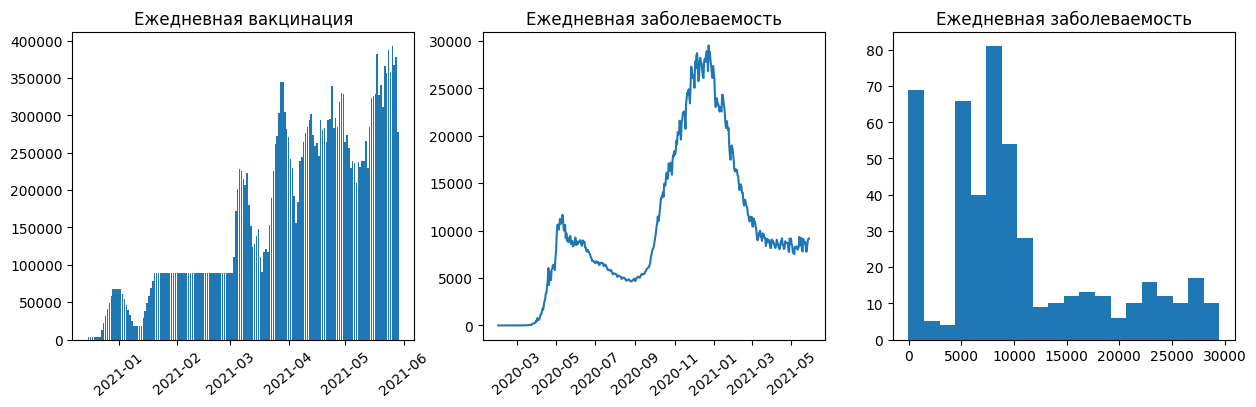

In [158]:

data_russia = covid_df[covid_df['country'] == 'Russia']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

# Столбчатая диаграмма, которая покажет динамику ежедневной вакцинации в России.
axes[0].bar(data_russia.date, height=data_russia.daily_vaccinations)
axes[0].set_title('Ежедневная вакцинация')
axes[0].xaxis.set_tick_params(rotation=40)

# Линейный график изменения ежедневной заболеваемости в стране.
axes[1].plot(data_russia.date, data_russia.daily_confirmed)
axes[1].set_title('Ежедневная заболеваемость')
axes[1].xaxis.set_tick_params(rotation=40)

# Гистограмма ежедневной заболеваемости в стране.
axes[2].hist(data_russia.daily_confirmed, bins=20)
axes[2].set_title('Ежедневная заболеваемость');

* На 1-м графике можно наблюдать колеблющийся рост числа ежедневно вакцинированных людей. Особенно в глаза бросается «пенёк» в период с конца января до начала марта 2021 года. Это период, когда данные о процессе вакцинации людей не обновлялись.

* На 2-м графике мы видим две волны коронавируса в России. Первая — в середине марта 2020 года, которая достигла максимума в 13 тысяч заболевших за сутки. Вторая волна, судя по графику, началась в октябре 2020 года и достигла своего пика почти в 30 тысяч заболевших за сутки в конце декабря этого же года (точные данные: 24 декабря было зафиксировано рекордное число подтверждённых случаев: 29935). Далее с ростом показателей вакцинации и введением новых карантинных мер заболеваемость снова постепенно снижается.

* На 3-м графике можно увидеть, что большая часть наблюдений ежедневной заболеваемости находится в интервале от 5 до до 10 тысяч человек в день. Ещё один пик гистограммы находится около 0 — это случаи, зафиксированные на начальных этапах эпидемии (в Россию Covid-19 пришёл позже, чем во многие другие страны).

In [160]:
countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head(2)

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate,population,daily_confirmed_per_hundred
0,2020-01-23,Australia,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-25,Australia,4.0,0.0,0.0,4.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

# общее распределение ежедневной заболеваемости
hist_confirmed = sn.hisplot(data=croped_covid_df, x='daily_confirmed', ax=axes[0])
hist_confirmed.set_title('Ежедневная заболеваемость')

# общее распределение ежедневной заболеваемости в разрезе стран
hist_confirmed = sn.hisplot(data=croped_covid_df, x='daily_confirmed', ргу='country', ax=axes[0])
hist_confirmed.set_title('Ежедневная заболеваемость')